# Caso de aplicación

## Portafolio óptimo

### Librerías

In [19]:
import random
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from matplotlib import cm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.optimize import minimize
from joblib import Parallel, delayed 
import matplotlib.colorbar as colorbar
from matplotlib.colors import Normalize
from IPython.display import display, Markdown

### Obtención de datos

In [20]:
#random.seed(42)
tickers=['WMT','AAPL','GOOGL','PG','JNJ','KO','MCD','SBUX']
tickers2 = ['VTI','VOO']

f_inicial='2020-01-01'
f_final='2024-11-23'

datos1=yf.download(tickers,f_inicial,f_final)['Adj Close']
datos2 = yf.download(tickers2,f_inicial,f_final)['Adj Close']

rt = datos1.pct_change().dropna()
rt2 = datos2.pct_change().dropna()

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  2 of 2 completed


### Cálculo de variables

In [21]:
mu = (rt.mean() * 252).values  # Rendimientos esperados
sigma = rt.cov().values  # Matriz de covarianza
sigma_inv = np.linalg.inv(sigma)  # Matriz de covarianza inversa
rf = 0.04413  # Tasa libre de riesgo
unos = np.ones(len(mu)) # Vector de unos
mu_rf = mu - np.dot(rf,unos) # Rendimientos esperados en exceso

### Obtención de $w$

In [22]:
w = np.dot(sigma_inv,mu_rf)/ np.dot(unos.T,np.dot(sigma_inv,mu_rf))

### Cálculo del retorno, volatilidad y Sharpe Ratio del portafolio

- $\mu_p = w^{^T}\mu$
- $\sigma_p = \sqrt{ w^{T} \Sigma w}$
- $sr = \frac{\mu_p - r_f}{\sigma_p}$

In [23]:
ret = np.dot(w.T, mu) # Rendimiento esperado del portafolio
risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252) # Volatilidad del portafolio
sharpe = (ret - rf) / risk # Sharpe ratio

### Resultados

In [24]:
w_df = pd.DataFrame(w, index=tickers, columns=['w'])

print(f'Rendimiento esperado: {ret:.6%}')
print(f'Volatilidad: {risk:.6%}')
print(f'Ratio de sharpe: {sharpe:.6f}')

display(Markdown('### Valores del vector $w$:'))
display(w_df.T)

Rendimiento esperado: 43.358689%
Volatilidad: 37.382748%
Ratio de sharpe: 1.041809


### Valores del vector $w$:

,WMT,AAPL,GOOGL,PG,JNJ,KO,MCD,SBUX
w,0.753564,0.213842,-0.773838,-0.427832,0.342416,0.186431,-0.353557,1.058974


### Backtest de Portafolio óptimo vs S&P 500

In [25]:
portfolio_returns = np.dot(rt, w)
cumulative_return_port = (1 + portfolio_returns).cumprod()
cumulative_return_sp = (1 + rt2['VOO']).cumprod()

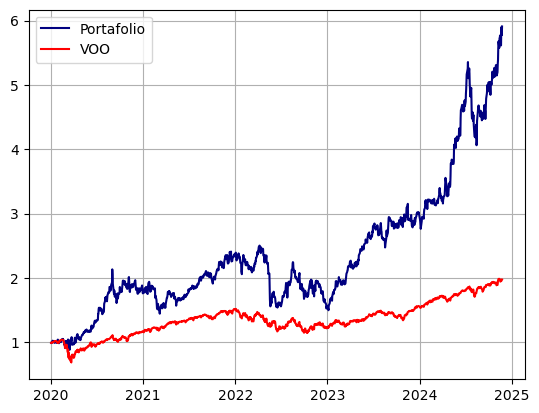

In [26]:
returns = pd.DataFrame({
    'portafolio': cumulative_return_port,
    'VOO': cumulative_return_sp
})
plt.plot(returns['portafolio'], label='Portafolio', c = 'navy')
plt.plot(returns['VOO'], label='VOO', c = 'red')

plt.legend()
plt.grid()

### Simulación de portafolios

In [27]:
# Para las simulaciones
sigma = rt.cov()
n_port = 10000
n_act = len(rt.keys())

W = np.random.dirichlet((1,) * n_act, size=n_port)

# Obten los rendimientos
rendimientos = W.dot(rt.mean()) * 252

# Calcula las volatilidades
zeros = np.zeros(n_port)
for i in range(len(zeros)):
    zeros[i] = np.sqrt(W[i,:].dot(sigma).dot(W[i,:])) * np.sqrt(252)
volatility = zeros

# Sharpe
sharpe = (rendimientos - rf) / volatility

# Data frame de resultados
resultados = pd.DataFrame({
    'rend': rendimientos,
    'vol': volatility,
    'sharpe': sharpe
})
pesos = pd.DataFrame(W, columns=rt.keys())
resultados = pd.concat([resultados, pesos], axis=1)

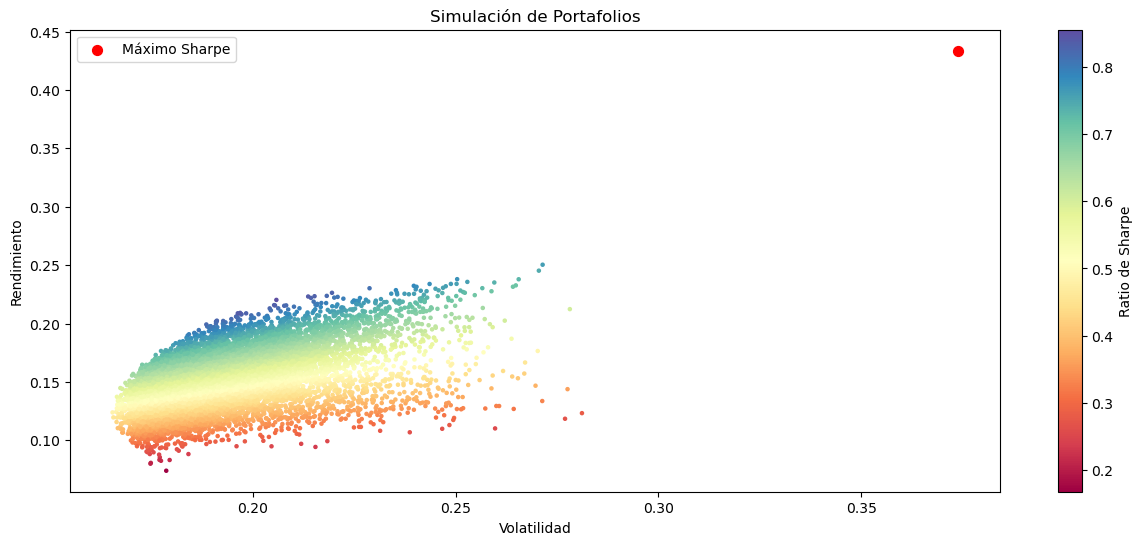

In [28]:
# Crear el gráfico con matplotlib
fig, ax = plt.subplots(figsize=(15, 6))

# Crear la normalización y el mapa de colores
norm = Normalize(vmin=min(sharpe), vmax=max(sharpe))
cmap = matplotlib.colormaps['Spectral']

# Crear el scatter plot
sc = ax.scatter(resultados['vol'], resultados['rend'], c=sharpe, cmap=cmap, norm=norm, s=5)
plt.scatter(risk, ret, color='red', s=50, label='Máximo Sharpe')

# Añadir la barra de colores
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Ratio de Sharpe')

# Añadir etiquetas
ax.set_title('Simulación de Portafolios')
ax.set_xlabel('Volatilidad')
ax.set_ylabel('Rendimiento')

# Mostrar el gráfico
plt.legend()
plt.show()

## Comparación pesos óptimos vs pesos aleatorios

### Funciones

In [29]:
tickers = ['AAPL', 'NVDA', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'SPOT', 'SBUX', 'JPM', 'AXP', 'MCD', 'KO', 
           'NFLX', 'CMG', 'CP', 'WMT', 'V', 'GLD', 'BLK', 'PG', 'JNJ', 'TMUS', 'MA', 'BX', 'LULU', 'DPZ', 'BAC', 
           'FDX', 'DIS', 'GE', 'HSY', 'HP', 'COST', 'HD', 'K', 'ADBE', 'CSCO', 'T', 'F', 'NKE', 'CVX', 'XOM', 'PYPL', 
           'PEP', 'PFE', 'MRNA', 'RL', 'AZN', 'BABA', 'VZ', 'WBD', 'HSBC', 'UBER']

def simulate_portfolio_opt(i, tickers, rf):
    sample_size = random.randint(2, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.dot(sigma_inv, mu_rf) / np.dot(unos.T, np.dot(sigma_inv, mu_rf))

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 100  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio_opt)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos_opt = [result[0] for result in results]
volatilidades_opt = [result[1] for result in results]
sharpe_ratios_opt = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  5 of 5 completedd
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completeded

[*********************100%***********************]  6 of 6 completedd
[*********************100%***********************]  4 of 4 completedd
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  8 of 8 completedd
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  6 of 6 completedd
[*********************1

In [30]:
def simulate_portfolio(i, tickers, rf):
    sample_size = random.randint(2, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.random.dirichlet(np.ones(len(mu)), size=1)[0]

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 100  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos = [result[0] for result in results]
volatilidades = [result[1] for result in results]
sharpe_ratios = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  5 of 5 completedd
[*********************100%***********************]  7 of 7 completedd
[*********************100%***********************]  4 of 4 completedd
[*********************100%***********************]  7 of 7 completed
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  9 of 9 completedd
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  5 of 5 completeded
[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  4 of 4 completedd
[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  2 of 2 completedd
[*********************100%***********************]  9 of 9 completed
[******************

In [31]:
def simulate_portfolio_short(i, tickers, rf):
    sample_size = random.randint(2, 15)
    random_tickers = random.sample(tickers, sample_size)

    datos1 = yf.download(random_tickers, f_inicial, f_final)['Adj Close']
    rt = datos1.pct_change().dropna()

    # Calcular retornos y matriz de covarianza
    mu = (rt.mean() * 252).values  # retornos esperados
    sigma = rt.cov().values  # Matriz de covarianza
    sigma_inv = np.linalg.inv(sigma)  # Inversa de la matriz de covarianza
    unos = np.ones(len(mu))  # Vector de unos
    mu_rf = mu - np.dot(rf, unos)  # Exceso de retornos esperados

    # Pesos óptimos
    w = np.random.uniform(-3, 3, len(mu))
    w /= np.sum(w)

    # Cálculo del retorno, volatilidad y sharpe del portafolio
    ret = np.dot(w.T, mu)  # Retorno esperado del portafolio
    risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)  # Volatilidad del portafolio
    sharpe = (ret - rf) / risk  # Sharpe ratio

    return ret, risk, sharpe, w

n_simulations = 100  # Simulaciones
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio_short)(i, tickers, rf) for i in range(n_simulations))

# Extract the results
retornos_short = [result[0] for result in results]
volatilidades_short = [result[1] for result in results]
sharpe_ratios_short = [result[2] for result in results]
# pesos_opt = [result[3] for result in results]

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  4 of 4 completedd
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  6 of 6 completedd
[*********************100%***********************]  5 of 5 completed
[**********************56%**                     ]  5 of 9 completedd
[*********************100%***********************]  2 of 2 completedd
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  4 of 4 completeded
[*********************100%***********************]  5 of 5 completeded
[*********************100%***********************]  7 of 7 completeded
[*********************100%***********************]  5 of 5 completeded
[*******************

In [32]:
metricas_optimas_df = pd.DataFrame({
    'rendimiento': retornos_opt,
    'volatilidad': volatilidades_opt,
    'sharpe': sharpe_ratios_opt
})

In [33]:
metricas_df = pd.DataFrame({
    'rendimiento': retornos,
    'volatilidad': volatilidades,
    'sharpe': sharpe_ratios
})

In [34]:
metricas_df_short = pd.DataFrame({
    'rendimiento': retornos_short,
    'volatilidad': volatilidades_short,
    'sharpe': sharpe_ratios_short
})

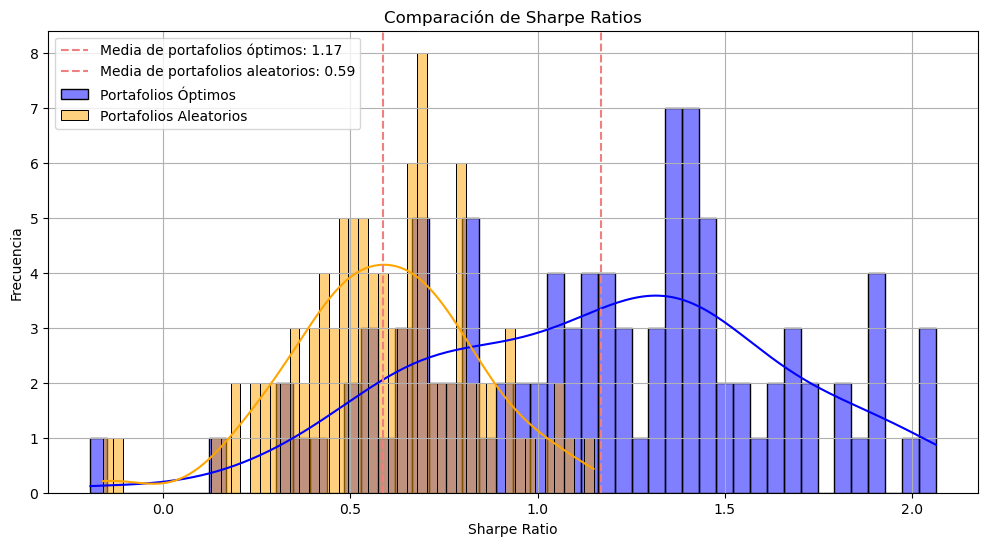

In [35]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df['sharpe'].mean()
random_mean = metricas_df['sharpe'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(random_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios aleatorios: {random_mean:.2f}')

plt.legend()
plt.title('Comparación de Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()

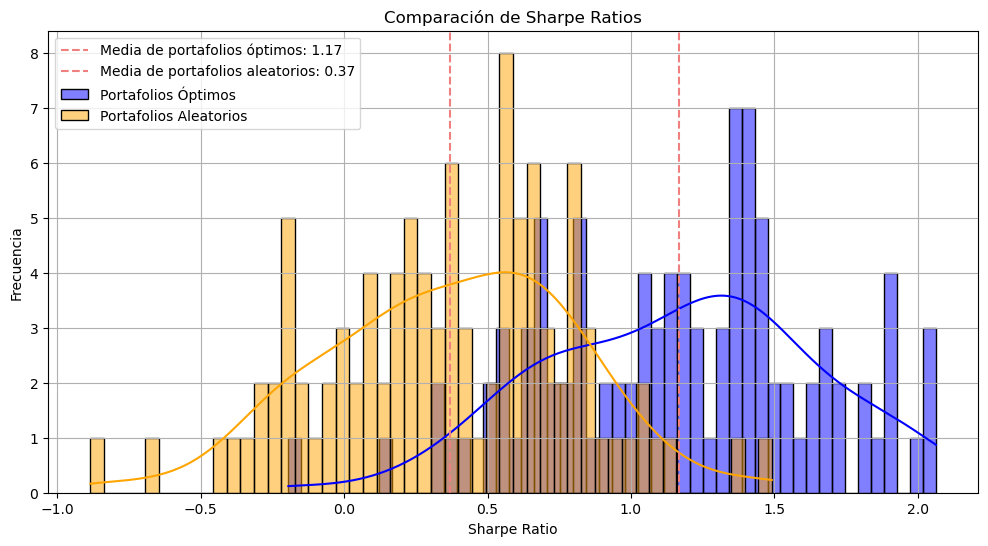

In [36]:
plt.figure(figsize=(12, 6))

sns.histplot(
    data=metricas_optimas_df['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='blue',
    label='Portafolios Óptimos'
)

sns.histplot(
    data=metricas_df_short['sharpe'], 
    bins=50,
    kde=True,  # Añade la curva de densidad
    color='orange',
    label='Portafolios Aleatorios'
)

opt_mean = metricas_optimas_df['sharpe'].mean()
short_mean = metricas_df_short['sharpe'].mean()

plt.axvline(opt_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios óptimos: {opt_mean:.2f}')
plt.axvline(short_mean, color='lightcoral', linestyle='--', label=f'Media de portafolios aleatorios: {short_mean:.2f}')

plt.legend()
plt.title('Comparación de Sharpe Ratios')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Frecuencia')
plt.grid()
plt.show()